In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import random
import cartopy.feature as cfeature
from VPRMout_fun  import EPSG32618_to_latlon

# Luke's domain
Lons = np.arange(-75.0, -72.5, 0.01) # Column number
Lats = np.arange(42.0, 40.0, -0.01)  # Row number
Lon, Lat = np.meshgrid(Lons, Lats)

# Dandan's domain
bbox=[563086.4981809029, 4483346.578300821, 609468.3374729961, 4530140.279354534]
upleft = EPSG32618_to_latlon([bbox[0], bbox[3]])
loleft = EPSG32618_to_latlon([bbox[0], bbox[1]])
loright = EPSG32618_to_latlon([bbox[2], bbox[1]])
upright = EPSG32618_to_latlon([bbox[2], bbox[3]])

delx = 609468.3374729961-563086.4981809029
dely = 4530140.279354534-4483346.578300821
print(upleft, upright)
print(loleft, loright)

(40.91994359299865, -74.25078580367983) (40.915050108690444, -73.70006247106176)
(40.498429317593086, -74.25549540873544) (40.493607634923094, -73.70823210074099)


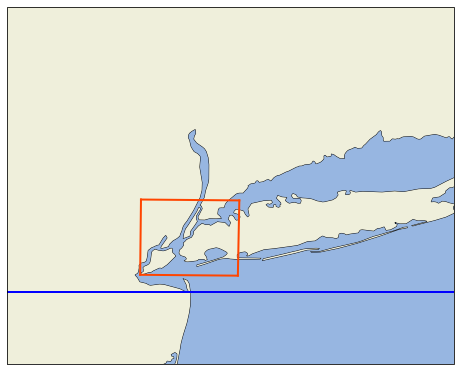

In [2]:
#set up a map
fig = plt.figure(figsize=(8, 12))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
# ax.set_extent([-122.8, -122, 37.3, 38.3]) # San Francisco
ax.set_extent([-75.0, -72.5, 40, 42])

# we can add high-resolution land
LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'],
                                        linewidth=.1)
# we can add high-resolution water
OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'],
                                        linewidth=.1)

ax.add_feature(LAND, zorder=0)
ax.add_feature(OCEAN)
# ax.pcolormesh(Lon, Lat, tmp, transform=ccrs.PlateCarree(), zorder=3)
# add a point to an image
ax.plot([upleft[1], upright[1]], [upleft[0],upright[0]],
         color='orangered', linewidth=2, transform=ccrs.PlateCarree())
ax.plot([upright[1], loright[1]], [upright[0],loright[0]],
         color='orangered', linewidth=2, transform=ccrs.PlateCarree())
ax.plot([loright[1], loleft[1]], [loright[0],loleft[0]],
         color='orangered', linewidth=2, transform=ccrs.PlateCarree())
ax.plot([loleft[1], upleft[1]], [loleft[0],upleft[0]],
         color='orangered', linewidth=2, transform=ccrs.PlateCarree())

ax.plot([-75, -72.5], [40.40, 40.40],
         color='blue', linewidth=2, transform=ccrs.PlateCarree())

plt.show()

In [ ]:
# # Get the center lat and lon of each small pixel
# Xdim_nyc, Ydim_nyc = np.meshgrid(Xdim, Ydim) 
# print(np.shape(Xdim_nyc)) # corresponds to Lon  
# print(np.shape(Ydim_nyc)) # corresponds to Lat  
# Xdim_1D = Xdim_nyc.reshape(np.size(Xdim_nyc))
# Ydim_1D = Ydim_nyc.reshape(np.size(Ydim_nyc))
# print(np.shape(Xdim_1D),np.shape(Ydim_1D))

# res = 30
# center_latlon = [EPSG32618_to_latlon([x+res/2.0, y-res/2.0])for x,y in zip(Xdim_1D,Ydim_1D)]
# center_lat = np.array([x for x,y in center_latlon])
# center_lon = np.array([y for x,y in center_latlon])

# # To create a dataframe with time, coordinates (X, Y), and EVI   
# Data = pd.DataFrame({"Center_lat":center_lat, "Center_lon":center_lon})
# Data.to_csv('/data0/dwei/VPRMout/NYC_domain_center_latlon')
# print(Data.head())

In [44]:
import datetime as dt  
import pandas as pd
import numpy as np
from netCDF4 import Dataset 
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ncdump import ncdump
import gdal
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from VPRM_params import NLCD_def, bbox
from VPRMout_fun import Read_VPRMout,latlon_to_EPSG32618,find_a_point_in_grids,get_first_dimension_ave,EPSG32618_to_latlon

# NLCD data
DataDir = '/data0/dwei/VPRMdata/'  # input dir
ds_nlcd = gdal.Open(DataDir+'nlcd_epsg32618_cropped.tif')
NLCD_2D = ds_nlcd.GetRasterBand(1).ReadAsArray()
# Remove water
# NLCD has zeros in the southeast corner; set them to 11 as water    
NLCD_2D[NLCD_2D==0] = 11  

Datadir = '/data0/dwei/VPRMout/'
file1 = 'DBF_2021-0415_20220315.nc' # before April 15
file2 = 'DBF_2021_0415_20220309.nc' # after April 15

# Read the file from April 15 8:00 to July 31 23:00
nc_fid = Dataset(Datadir+file2, 'r')  
Xdim  = nc_fid.variables['Xdim'][:] 
Ydim  = nc_fid.variables['Ydim'][:] 
time  = nc_fid.variables['time'][:]

# The time period interested
st=dt.datetime.timestamp(dt.datetime(2021, 5, 28, 0, 0, 0))
ed= dt.datetime.timestamp(dt.datetime(2021, 6, 2, 0, 0, 0))
ind_st = np.where(time == st)[0][0]
ind_ed = np.where(time == ed)[0][0]
print(ind_st)
print(ind_ed)
Time = time[ind_st:ind_ed]
GEE   = nc_fid.variables['GEE'][ind_st:ind_ed,:,:]  # GEE   [mol m^-2 hr^-1']
Res_H = nc_fid.variables['RESH'][ind_st:ind_ed,:,:] # Res_H [mol m^-2 hr^-1']
Res_A = nc_fid.variables['RESA'][ind_st:ind_ed,:,:] # Res_A [mol m^-2 hr^-1']
NEE   = GEE+Res_H+Res_A
TMP   = nc_fid.variables['TEMP'][ind_st:ind_ed,:,:] 
PAR   = nc_fid.variables['PAR'][ind_st:ind_ed,:,:] 
nc_fid.close()

# Remove water
TMP[:, NLCD_2D==11] = np.nan
PAR[:, NLCD_2D==11] = np.nan
GEE[:, NLCD_2D==11] = np.nan


1024
1144


(120,)


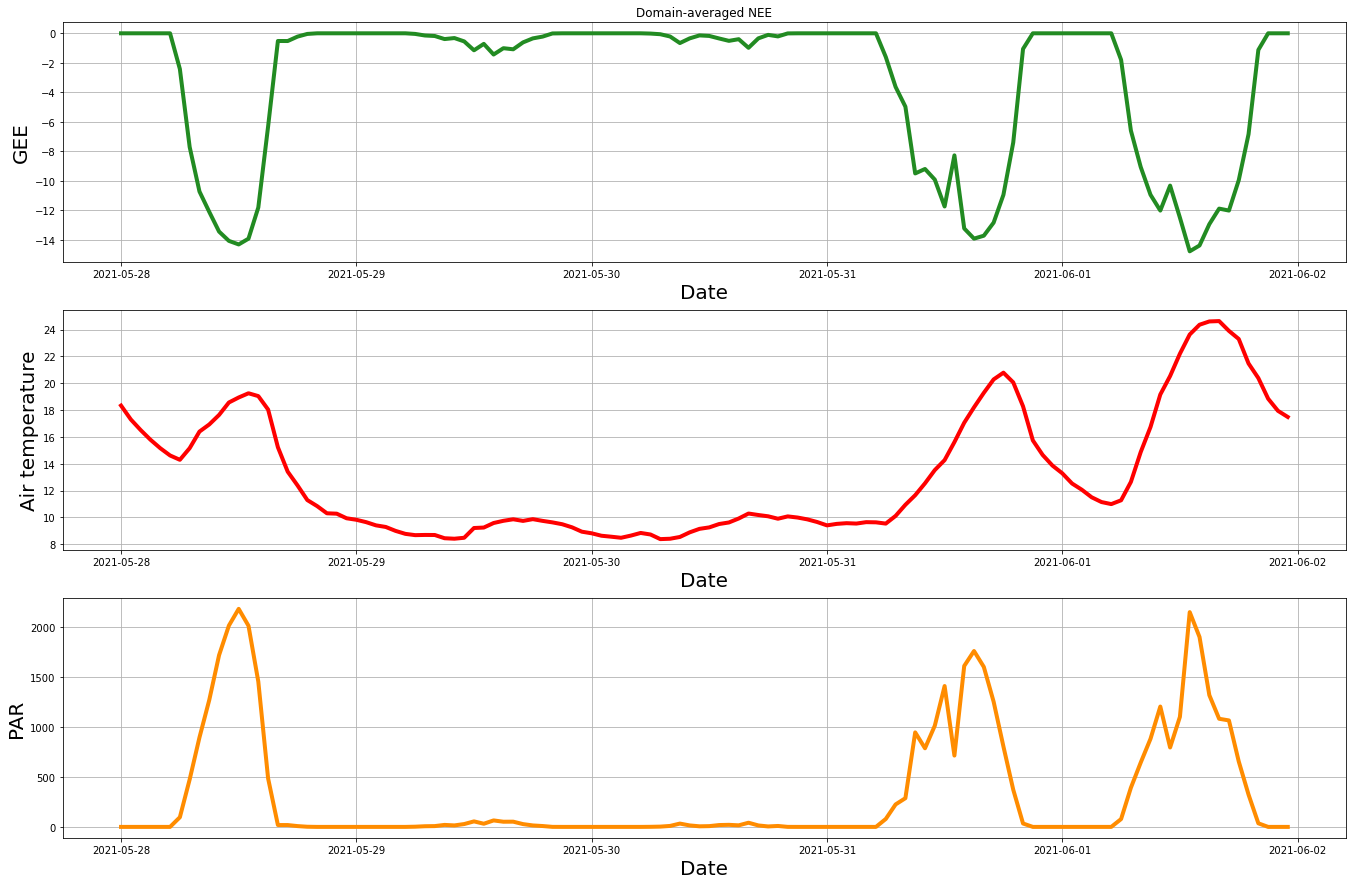

In [45]:
# Time series of domain averages
TMP_ave = np.array([np.nanmean(TMP[x, :, :]) for x in range(0, len(Time))])
PAR_ave = np.array([np.nanmean(PAR[x, :, :]) for x in range(0, len(Time))])
GEE_ave = np.array([np.nanmean(GEE[x, :, :]) for x in range(0, len(Time))])

DT_dates = np.array([dt.datetime.fromtimestamp(t) for t in Time])
DT_month = np.array([dt.date.fromtimestamp(t) for t in Time])
print(np.shape(DT_dates))

fig = plt.figure(figsize=(23,15))
FontSize = 20
LineWidth =4
row = 3
col = 1

ax = fig.add_subplot(row, col, 1)
ax.set_title('Domain-averaged NEE')
ax.plot(DT_dates, GEE_ave, color='forestgreen', linewidth=LineWidth)
# ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('GEE', fontsize = FontSize)
ax.set_xlabel('Date', fontsize = FontSize)
ax.grid()

ax = fig.add_subplot(row, col, 2)
ax.plot(DT_dates, TMP_ave, color='red', linewidth=LineWidth)
# ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('Air temperature', fontsize = FontSize)
ax.set_xlabel('Date', fontsize = FontSize)
ax.grid()

ax = fig.add_subplot(row, col, 3)
ax.plot(DT_dates, PAR_ave, color='darkorange', linewidth=LineWidth)
# ax.set_xticks(range(0, 24, 4))
ax.set_ylabel('PAR', fontsize = FontSize)
ax.set_xlabel('Date', fontsize = FontSize)
ax.grid()
